## MCX simulation Stage 3.1

In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bjdata: filename=bjdata-0.4.1-cp311-cp311-linux_x86_64.whl size=22196 sha256=2e83f3a8a15cbda812dcb4febdfb49a626ec30ea641b0f5434623ba5b3b8e3c2
  Stored in directory: /root/.cache/pip/wheels/e4/d5/4a/8d5ccb70c0eb1f07a10da8548e50b7fc0cbdfd014f5eaa45c3
Successfully built bjdata


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/MyDrive/MCX_data'
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms

In [4]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### MCX Simulation using packgae

In [5]:
import pmcx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
from FD_msNIRS import mcx_fft as mf
from FD_msNIRS import extract_freq as ef

In [6]:
g=0.85
wls = [784, 800, 818, 835, 851, 868, 881, 894]
ua = np.array([0.223727, 0.22862, 0.243825, 0.268655, 0.282601, 0.2926, 0.298296, 0.302246])  # cm-1
us_prime = [11.72500039, 11.34953514, 10.94990801, 10.59300387, 10.27399906, 9.95177998, 9.71627626, 9.48967415] # cm-1
us = np.array([x/(1-g) for x in us_prime])
distance = [2, 2.5, 3, 3.5] # cm

In [7]:
us

array([78.16666927, 75.6635676 , 72.99938673, 70.6200258 , 68.49332707,
       66.34519987, 64.77517507, 63.26449433])

In [8]:
# compute ua, distance, and us in mm-1
ua_mm = ua/10
us_mm = us/10
distance_mm = [d*10 for d in distance]

In [9]:
ua_mm

array([0.0223727, 0.022862 , 0.0243825, 0.0268655, 0.0282601, 0.02926  ,
       0.0298296, 0.0302246])

In [10]:
us_mm

array([7.81666693, 7.56635676, 7.29993867, 7.06200258, 6.84933271,
       6.63451999, 6.47751751, 6.32644943])

### Run simulations

In [11]:
dictt_ms = {}
for i in range(0, len(distance_mm)): # loop each distance(4)
  d = distance_mm[i]
  print('distance (mm) = ', d)
  for j in range(0, ua_mm.shape[0]): # loop each ua and us (8 wevelengths)
    print('ua = ', ua_mm[j])
    print('us = ', us_mm[j])
    TPSF, time_unit = ms(ua_mm[j], us_mm[j], g=0.85, n=1.370, distance = d, tend =1e-08, devf = 1000, nphoton = 1.2e8)
    dictt_ms[f'{d}, {wls[j]}'] = [TPSF, time_unit]

distance (mm) =  20
ua =  0.022372700000000002
us =  7.816666926666666
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.022862
us =  7.56635676
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.024382499999999998
us =  7.299938673333332
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.026865499999999997
us =  7.06200258
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.0282601
us =  6.849332706666665
nphoton: 1.2e+08
tstart: 0
tstep: 1e-11
tend: 1e-08
maxdetphoton: 1.2e+08
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua =  0.02926
us =  6.634519986666665
nphoton: 1.2e+08
tstart: 0
ts

In [12]:
target_freq = 110e6
uac = []
udc = []
phase1 = []
phase2 = []

for k, v in dictt_ms.items():
    TPSF, tstep = v
    uac_i, udc_i, p1, p2 = ef(target_freq, TPSF, tend=1e-08, devf=1000)
    uac.append(uac_i)
    udc.append(udc_i)
    phase1.append(p1)
    phase2.append(p2)

In [13]:
udc[0]

np.float64(8.657670346855443e-06)

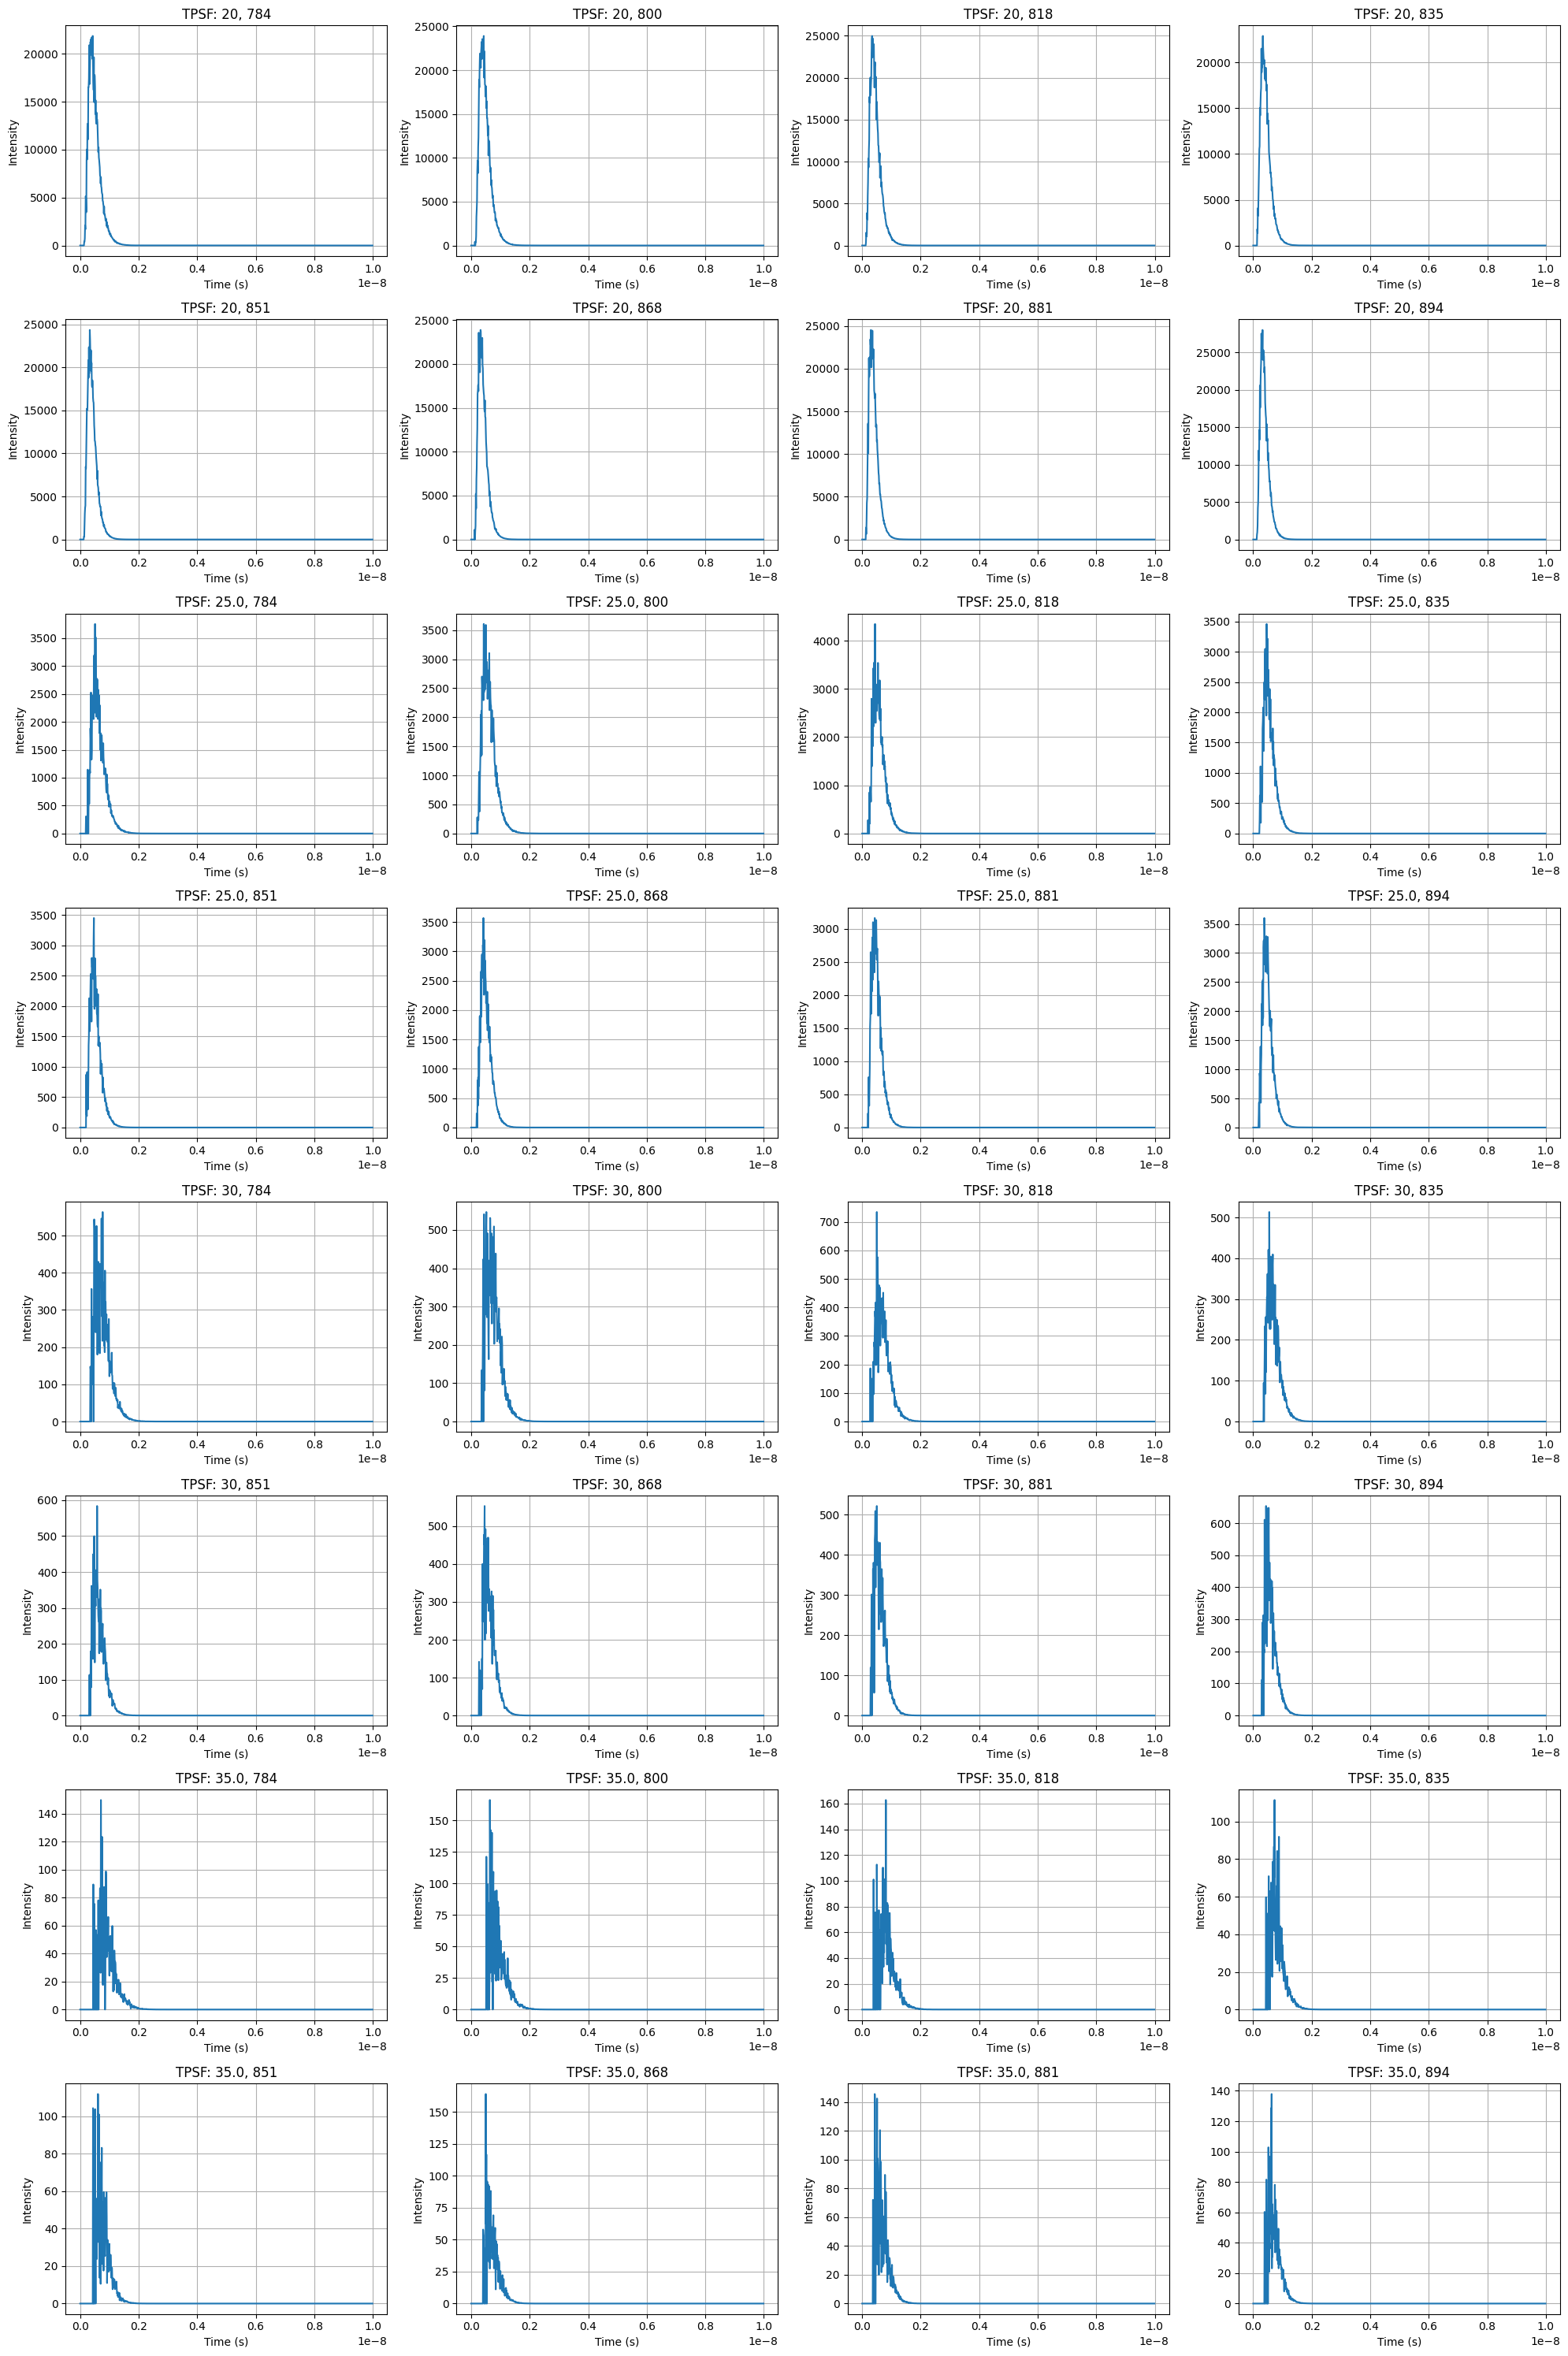

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(8, 4,  figsize=(20, 30))  # 8 rows, 4 columns
axes = axes.flatten()  # Flatten for easy indexing

for idx, (label, (TPSF, time_unit)) in enumerate(dictt_ms.items()):

    # Reconstruct time vector
    t = np.arange(len(TPSF)) * time_unit

    # Plot
    axes[idx].plot(t, TPSF)
    axes[idx].set_title(f"TPSF: {label}")
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Intensity")
    axes[idx].grid(True)

# Remove empty subplots if any
for i in range(len(dictt_ms), 8):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


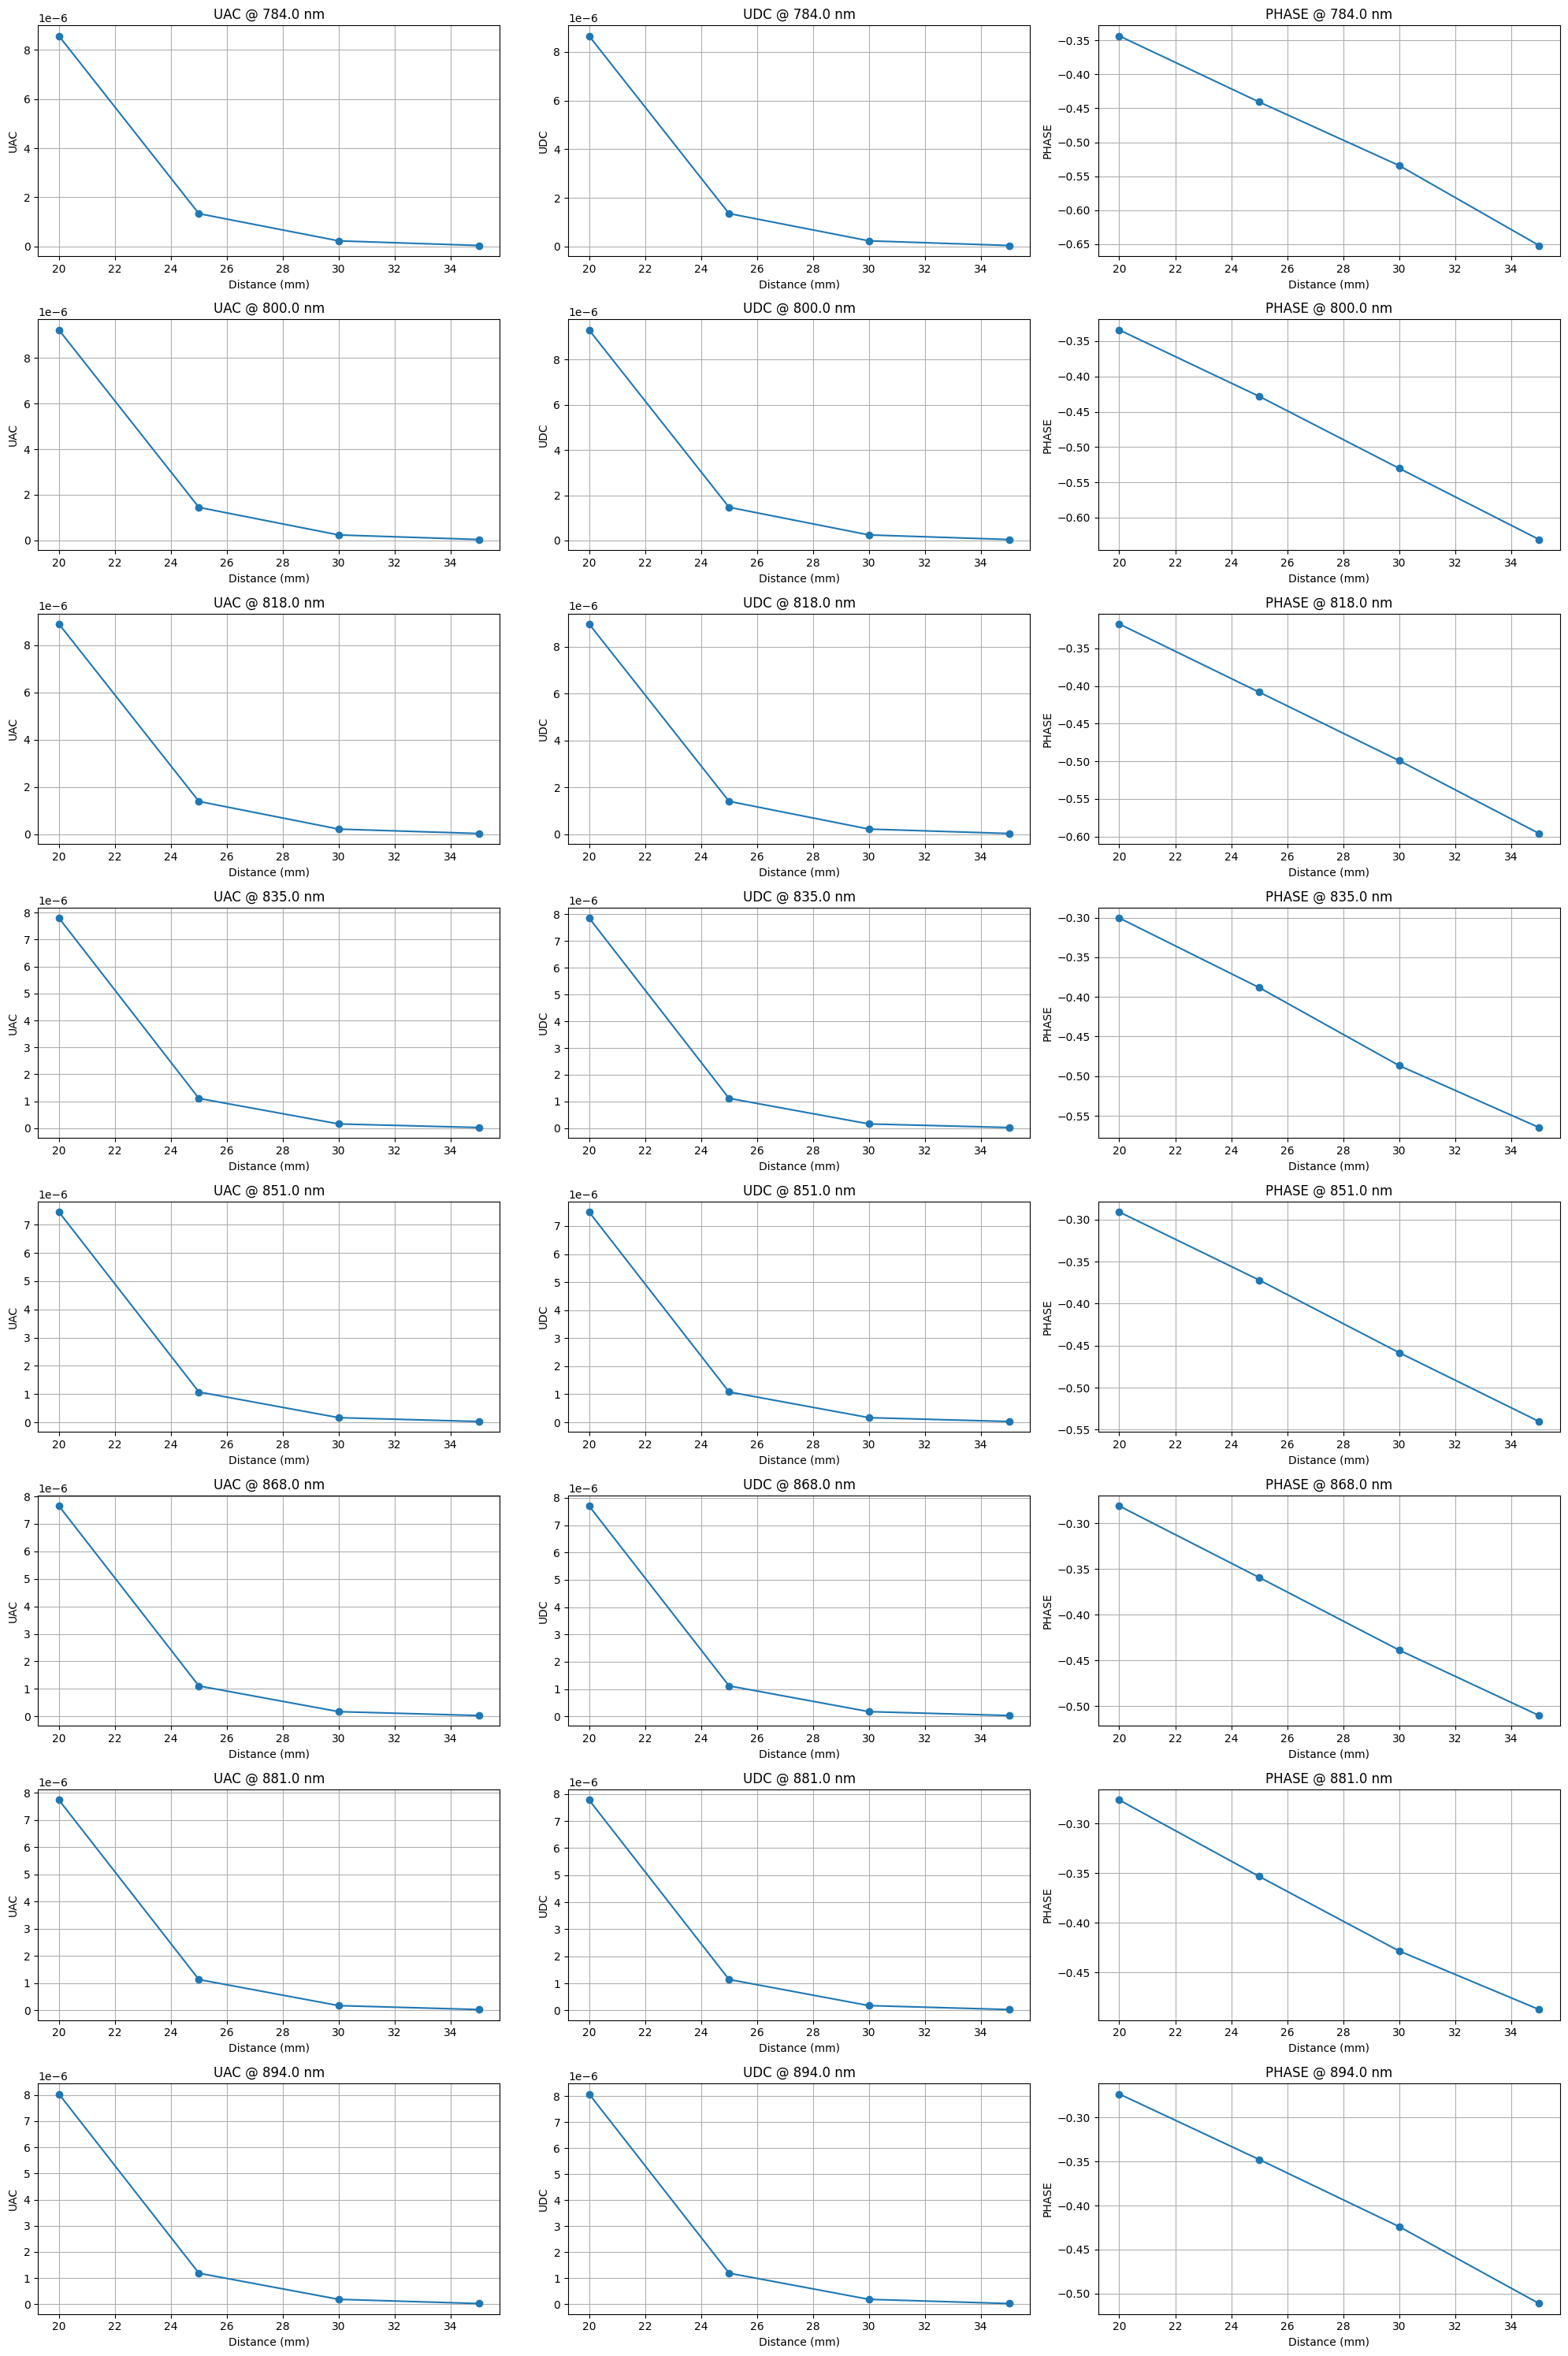

In [27]:
# Group data by wavelength
data_by_wl = {}
for (key, (TPSF, tstep)), uac_i, udc_i, p1, p2 in zip(dictt_ms.items(), uac, udc, phase1, phase2):
    dist_str, wl_str = key.split(',')  # split key: "distance, wavelength"
    wl = float(wl_str.strip())
    d = float(dist_str.strip())

    if wl not in data_by_wl:
        data_by_wl[wl] = {'distance': [], 'uac': [], 'udc': [], 'phase': []}

    data_by_wl[wl]['distance'].append(d)
    data_by_wl[wl]['uac'].append(uac_i)
    data_by_wl[wl]['udc'].append(udc_i)
    data_by_wl[wl]['phase'].append(p1)

# Sort by wavelength
sorted_wls = sorted(data_by_wl.keys())

# Plotting
fig, axes = plt.subplots(8, 3, figsize=(20, 30))
metrics = ['uac', 'udc', 'phase']
titles = ['UAC', 'UDC', 'PHASE']

for row in range(8):
    wl = sorted_wls[row]
    data = data_by_wl[wl]
    distances = data['distance']

    for col in range(3):
        ax = axes[row, col]
        metric = metrics[col]
        ax.plot(distances, data[metric], marker='o')
        ax.set_title(f"{titles[col]} @ {wl} nm")
        ax.set_xlabel("Distance (mm)")
        ax.set_ylabel(titles[col])
        ax.grid(True)

plt.tight_layout()
plt.show()


In [28]:
import pandas as pd
columns = []
row = []
counter = 0
for i in range(len(distance_mm)): # 4 distances
  distance= distance_mm[i]
  for j in range(len(wls)): # 8 wavelengths
    wl = wls[j]
    columns.extend([
        f"U_AC_{i+1}_{j+1}",
        f"U_DC_{i+1}_{j+1}",
        f"Phase_{i+1}_{j+1}"
    ])
    row.extend([uac[counter], udc[counter], phase1[counter]])
    counter = counter + 1

df = pd.DataFrame([row], columns=columns)
df.to_csv("stage3_1.csv", index=False)

In [17]:
phase2

[np.float64(-0.34413622916177883),
 np.float64(-0.3347086251364709),
 np.float64(-0.3182324937532263),
 np.float64(-0.30076006974239256),
 np.float64(-0.2911343455895405),
 np.float64(-0.28135752817449194),
 np.float64(-0.2765633106336353),
 np.float64(-0.273596120489305),
 np.float64(-0.4415833293724069),
 np.float64(-0.42900615304149664),
 np.float64(-0.4089697035875431),
 np.float64(-0.3887665652211248),
 np.float64(-0.37233897548037276),
 np.float64(-0.35965836725955286),
 np.float64(-0.3537737793393219),
 np.float64(-0.3481358045547123),
 np.float64(-0.5353739195851488),
 np.float64(-0.5311953079789329),
 np.float64(-0.4999848944774802),
 np.float64(-0.48737128201325874),
 np.float64(-0.45889823128977836),
 np.float64(-0.4392108017481115),
 np.float64(-0.4290525891922667),
 np.float64(-0.4245188246119661),
 np.float64(-0.6532936607346884),
 np.float64(-0.632369044795167),
 np.float64(-0.5968989349995297),
 np.float64(-0.565664322008518),
 np.float64(-0.5411212892937795),
 np.float

In [18]:
phase1

[np.float64(-0.3434688492327075),
 np.float64(-0.33409522444342643),
 np.float64(-0.3177178119975708),
 np.float64(-0.30036235906931263),
 np.float64(-0.2907829027714012),
 np.float64(-0.2810428989765916),
 np.float64(-0.2762698278074063),
 np.float64(-0.2733131321235511),
 np.float64(-0.44067804657721676),
 np.float64(-0.4281880156181051),
 np.float64(-0.4082699175382582),
 np.float64(-0.3882092324488468),
 np.float64(-0.37186492955908107),
 np.float64(-0.3592250374462716),
 np.float64(-0.3533711109461666),
 np.float64(-0.34775255414356965),
 np.float64(-0.5342117368359273),
 np.float64(-0.5301789579544194),
 np.float64(-0.49910762791378055),
 np.float64(-0.4866677466753734),
 np.float64(-0.4582987933030114),
 np.float64(-0.43865441436098107),
 np.float64(-0.428530707627825),
 np.float64(-0.42400245131490616),
 np.float64(-0.6519182518725769),
 np.float64(-0.6310076396454869),
 np.float64(-0.5958863080890978),
 np.float64(-0.564813757156656),
 np.float64(-0.5403650158045872),
 np.floa